# Raid West Trail 2025 Analysis

## Installing dependencies

In [77]:
!pip install gpxpy pandas matplotlib pytz geopy

You should consider upgrading via the 'c:\users\kheri\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


In [148]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
import gpxpy.gpx
from geopy.distance import geodesic
from datetime import timedelta
import math
import numpy as np

### Loading GPX files

In [10]:
# loading recon file
with open('./data/raid_west_recon.gpx', 'r') as recon_gpx_file:
    recon_gpx = gpxpy.parse(recon_gpx_file)
    
# loading race file
with open('./data/raid_west_race.gpx', 'r') as race_gpx_file:
    race_gpx = gpxpy.parse(race_gpx_file)

In [45]:
def generate_dataframe(gpx):
    # Extract track points
    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                data.append([point.time, point.latitude, point.longitude, point.elevation])

    # Create DataFrame
    df = pd.DataFrame(data, columns=['time', 'latitude', 'longitude', 'elevation'])
    
    # Convert time column to datetime
    df['time'] = pd.to_datetime(df['time'])
    
    # removing timezone information to prevent issues when plotting
    df['time'] = df['time'].dt.tz_localize(None)
    return df

### Display Elevation Profile

In [60]:
def display_elevation_profile(df, plot_title):
    # Plot elevation profile
    plt.figure(figsize=(10, 5))
    plt.plot(df['time'], df['elevation'])
    plt.xlabel('Time')
    plt.ylabel('Elevation (m)')
    plt.title(plot_title)
    plt.show()

### Display Elevation Profile for Recon

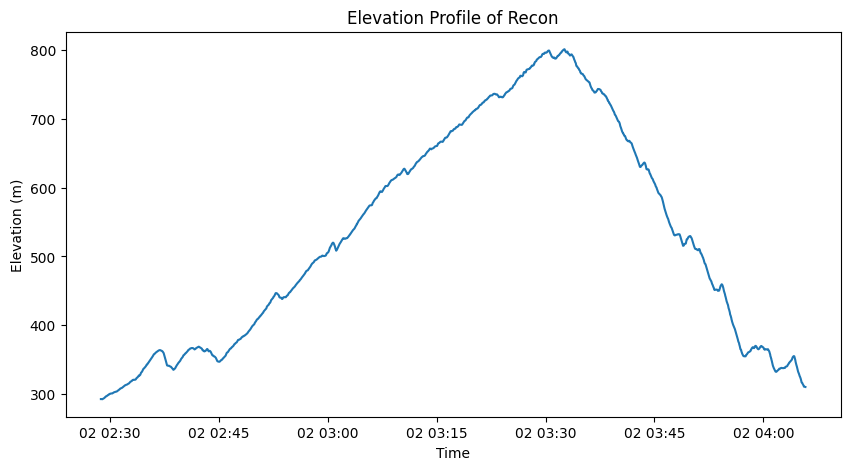

In [61]:
display_elevation_profile(generate_dataframe(recon_gpx), 'Elevation Profile of Recon')

### Display Elevation Profile for Race

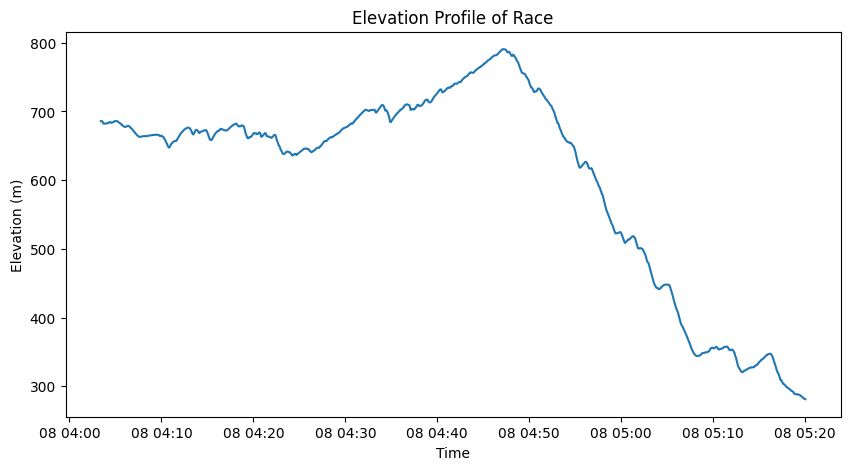

In [63]:
display_elevation_profile(generate_dataframe(race_gpx), 'Elevation Profile of Race')

In [167]:
recon_df = generate_dataframe(recon_gpx)
print(f"Highest point of recon is: {round(recon_df['elevation'].max(), 2)}")
print(f"Lowest point of recon is: {round(recon_df['elevation'].min(), 2)}")

Highest point of recon is: 801.4
Lowest point of recon is: 292.4


In [52]:
race_df = generate_dataframe(race_gpx)
print(f"Highest point of race is {round(race_df['elevation'].max(), 2)}")
print(f"Lowest point of race is: {round(race_df['elevation'].min(), 2)}")

Highest point of race is 790.6
Lowest point of race is: 281.2


Since I'm concerned with a specific segment of the trail (mainly the descent), I am going to extract only the segment which starts roughly from the start of the mountain to the end at the bottom. Again, the start and end of the extracted segment will be approximations based (visually) on the above plot. 

### Extracting Recon Segment

In [169]:
recon_segment_start_time = pd.Timestamp('2025-02-02 03:32:37')
recon_segment_df = recon_df[(recon_df['time'] > recon_segment_start_time)]

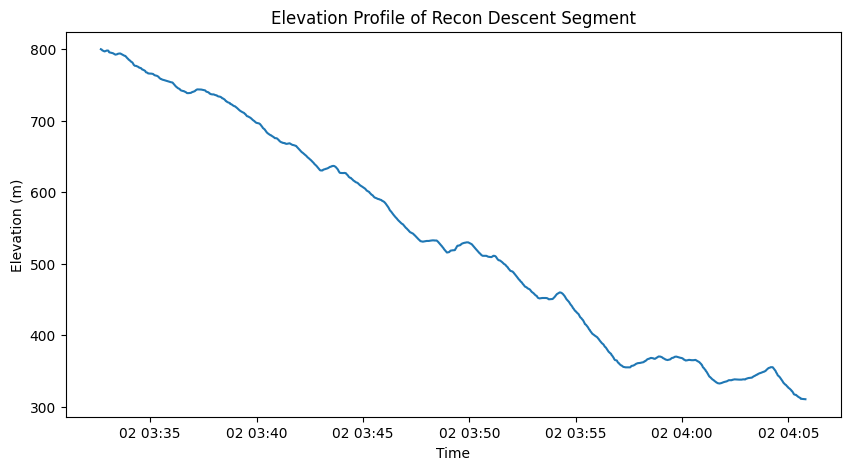

In [75]:
display_elevation_profile(recon_segment_df, 'Elevation Profile of Recon Descent Segment')

### Extracting Race Segment

In [171]:
race_segment_start_time = pd.Timestamp('2025-02-08 04:47:14')
race_segment_df = race_df[(race_df['time'] > race_segment_start_time)]

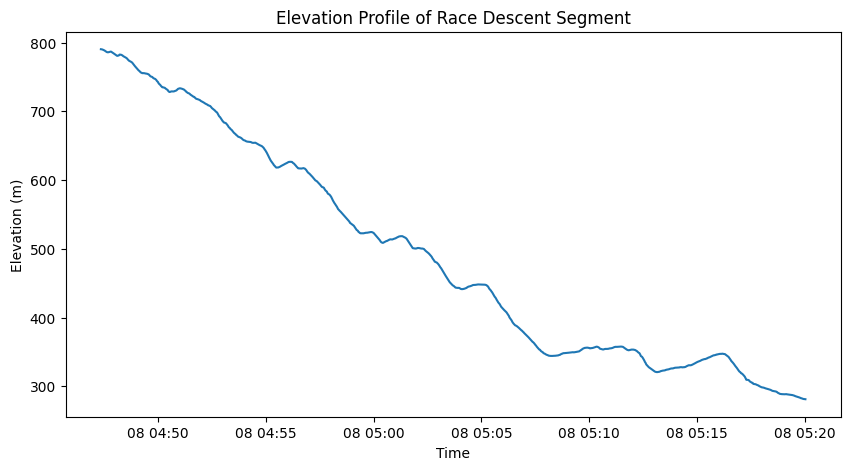

In [74]:
display_elevation_profile(race_segment_df, 'Elevation Profile of Race Descent Segment')

In [177]:
def find_average_pace(df):
    # Initialize variables
    total_distance = 0.0  # in kilometers
    total_time = timedelta(0)

    for index in range(1, len(df)):
        # Current and previous points
        prev_point = df.iloc[index-1]
        curr_point = df.iloc[index]

        # Calculate distance between points (in kilometers)
        if not any(np.isnan(np.array([prev_point['latitude'], prev_point['longitude'], curr_point['latitude'], curr_point['longitude']]))):
            coords_1 = (prev_point['latitude'], prev_point['longitude'])
            coords_2 = (curr_point['latitude'], curr_point['longitude'])
            distance = geodesic(coords_1, coords_2).kilometers
            total_distance += distance

            # check for identical timestamps
            if prev_point['time'] == curr_point['time']:
                time_diff = timedelta(0)
            else:
                time_diff = curr_point['time'] - prev_point['time']

            # Calculate time difference between points
            time_diff = curr_point['time'] - prev_point['time']

            # Calculate current pace
            df.at[index, 'pace'] = time_diff / distance
            total_time += time_diff
    # Calculate average pace (time per kilometer)
    average_pace_per_km = total_time / total_distance
    
    print(f'Total Distance: {total_distance} kilometers')
    print(f'Total Time: {get_seconds(total_time)}')
    print(f'Average Pace: {get_seconds(average_pace_per_km)} min/km')

In [178]:
# utility function to get seconds only from timedelta object
def get_seconds(timedelta_obj):
    total_seconds = timedelta_obj.total_seconds()
    time_only_seconds = total_seconds % (24 * 3600)  # Seconds in a day
    time_only_delta = timedelta(seconds=time_only_seconds)
    return time_only_delta

In [179]:
find_average_pace(race_segment_df)

Total Distance: 3.943565436864049 kilometers
Total Time: 0:32:41
Average Pace: 0:08:17.265743 min/km


In [180]:
find_average_pace(recon_segment_df)

Total Distance: 3.755189186947717 kilometers
Total Time: 0:33:07
Average Pace: 0:08:49.134459 min/km
